In [116]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np
import os

In [117]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [118]:
#df = pd.read_csv("../../data/current_clean_spectrum.csv")
#df = pd.read_csv("../../data/initial_parameters.csv")
df = pd.read_csv("../../data/groupkfold_parameters.csv")

In [119]:
# def normalise(absorbances):
#     max_value = np.max(absorbances)
#     normalized_absorbances = absorbances / max_value
#     return normalized_absorbances

# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

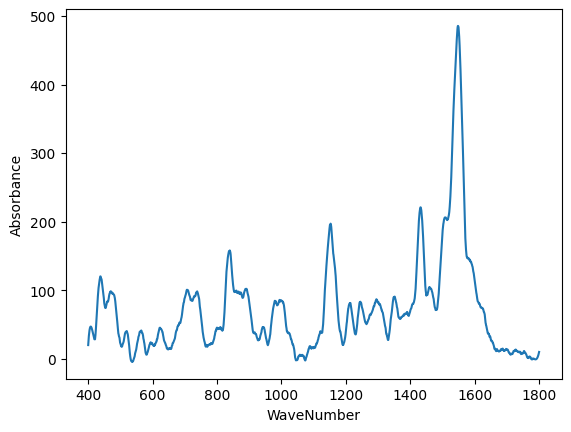

In [120]:
sample = df[df['SpecID'] == "210526-3-06"]
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

In [121]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


In [122]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [123]:
pivot_df = prepare_wavelength_df(df, 'Absorbance')

# Train

In [124]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = pivot_df.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

In [125]:
def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 4000 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)

# Convert the kernel matrix to a DataFrame
train_kernel_df = pd.DataFrame(kernel_matrix, index=pivot_df.index, columns=pivot_df.index)

In [126]:
train_kernel_df

SpecID,201210-1-00,201210-1-01,201210-1-02,201210-1-03,201210-1-04,201210-1-05,201210-1-06,201210-1-07,201210-1-09,201210-1-10,...,210526-3-40,210526-3-41,210526-3-42,210526-3-43,210526-3-44,210526-3-45,210526-3-46,210526-3-47,210526-3-48,210526-3-49
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.960222,0.185942,0.016573,0.840565,0.733965,0.732632,0.835303,0.871049,0.918058,...,0.938829,0.937744,0.928191,0.936565,0.939272,0.935973,0.934493,0.931532,0.934876,0.932618
201210-1-01,0.960222,1.000000,0.232076,0.022232,0.889082,0.796927,0.780446,0.853169,0.878050,0.900857,...,0.886819,0.888595,0.875283,0.877737,0.876936,0.871103,0.869375,0.862815,0.867528,0.864865
201210-1-02,0.185942,0.232076,1.000000,0.093867,0.186239,0.179427,0.161619,0.174763,0.184361,0.170892,...,0.134140,0.135923,0.132599,0.131456,0.130767,0.128275,0.129061,0.132162,0.128803,0.127268
201210-1-03,0.016573,0.022232,0.093867,1.000000,0.019366,0.020385,0.020779,0.020482,0.021064,0.016993,...,0.011996,0.012505,0.011572,0.011160,0.010909,0.010474,0.010403,0.010595,0.010520,0.010335
201210-1-04,0.840565,0.889082,0.186239,0.019366,1.000000,0.944775,0.838830,0.851480,0.847944,0.857373,...,0.795307,0.797210,0.780925,0.780141,0.771758,0.765216,0.764966,0.751632,0.756838,0.760434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,0.935973,0.871103,0.128275,0.010474,0.765216,0.667469,0.703940,0.812829,0.845956,0.905551,...,0.991602,0.990718,0.989267,0.996821,0.998090,1.000000,0.998439,0.996584,0.997715,0.996144
210526-3-46,0.934493,0.869375,0.129061,0.010403,0.764966,0.667889,0.705907,0.815392,0.848672,0.908035,...,0.989657,0.989563,0.987226,0.996412,0.997430,0.998439,1.000000,0.997415,0.998216,0.997198
210526-3-47,0.931532,0.862815,0.132162,0.010595,0.751632,0.653123,0.692555,0.804758,0.839827,0.899218,...,0.984855,0.983818,0.982331,0.992953,0.995056,0.996584,0.997415,1.000000,0.997795,0.995702


In [127]:
train_nodes_df = pivot_df['Status'].to_frame()
train_nodes_df = train_nodes_df.rename_axis("SpecID:ID")
train_nodes_df = train_nodes_df.rename(columns={"Status": ":LABEL"})

In [128]:
train_nodes_df.to_csv(f"{neo4j_directory}/import/nodes.csv")

In [129]:
train_relationship_df = train_kernel_df.reset_index()
train_relationship_df = train_relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
train_relationship_df = train_relationship_df.rename(columns={'SpecID': ':START_ID'})
train_relationship_df[':TYPE'] = 'LINK'

In [130]:
train_relationship_df = train_relationship_df[train_relationship_df[":START_ID"] != train_relationship_df[":END_ID"]]
train_relationship_df = train_relationship_df[train_relationship_df[":START_ID"] < train_relationship_df[":END_ID"]]

In [131]:
train_relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv")

In [132]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [133]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data/databases/neo4j:\nNodes:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/nodes.csv\n\nRelationships:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 15.47GiB\n  Free machine memory: 4.118GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 8\n  Configured max memory: 2.924GiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'Weight' normalized from 'float' --> 'double' in /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\nImport s

In [134]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j........ stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5\nconfig:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/conf\nlogs:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/logs\nplugins:      /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/plugins\nimport:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import\ndata:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data\ncertificates: /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ff

Run and connect to the Neo4j Database

In [135]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at teh top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [136]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Unable to retrieve routing information
Transaction failed and will be retried in 0.8982590985183546s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 1.8802454680763283s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 3.664615991217176s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 7.130861983664424s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 19.194589648564968s (Unable to retrieve routing information)


Define the graph algorithms.

In [137]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [138]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [139]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [140]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [141]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [142]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [143]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [144]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [145]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'Weight',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [146]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [147]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'Louvain'])

In [148]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['name'], how='left')

In [149]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210504-1-29,8.063099,2.118526e-10,0.0,0.150000,54,2394
1,210505-1-11,6.324768,2.060467e-02,0.0,0.150001,147,2525
2,210510-2-43,5.510720,1.276318e-01,0.0,0.150005,21,2658
3,210505-1-10,5.496797,2.045747e-02,0.0,0.150001,147,2525
4,210504-1-33,5.463643,9.491556e-08,0.0,0.150000,8,2527
...,...,...,...,...,...,...,...
3040,210303-2-26,0.150000,3.713241e-46,0.0,0.150000,1,1381
3041,210304-2-02,0.150000,3.942857e-144,0.0,0.150000,223,336
3042,210324-2-34,0.150000,5.486276e-41,0.0,0.150000,6,477
3043,210407-1-03,0.150000,4.587602e-42,0.0,0.150000,35,1701


In [150]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,-0.126921,0.029483,0.313777,0.217399,0.141151,-0.116146,0.036769,-0.075381,0.028979,...,-0.197569,-0.007299,-0.104828,0.108536,0.310620,-0.044107,0.028253,-0.101956,-0.004545,-0.022226
1,201210-1-01,-0.124933,0.028509,0.312783,0.214692,0.141758,-0.115651,0.036883,-0.077285,0.030259,...,-0.197404,-0.007553,-0.102692,0.109560,0.310848,-0.044121,0.027004,-0.103600,-0.003526,-0.023261
2,201210-1-02,-0.121030,0.026722,0.311113,0.209621,0.142960,-0.114374,0.036854,-0.080790,0.032723,...,-0.197173,-0.008203,-0.098837,0.111467,0.311111,-0.044168,0.024581,-0.106579,-0.001555,-0.024959
3,201210-1-03,-0.100998,0.012337,0.301661,0.183001,0.148147,-0.110117,0.034071,-0.099429,0.046803,...,-0.195584,-0.005931,-0.080722,0.120950,0.312045,-0.049881,0.012532,-0.125008,0.004476,-0.031517
4,201210-1-04,-0.122028,0.026827,0.311272,0.210577,0.142558,-0.115046,0.036947,-0.080157,0.032158,...,-0.197155,-0.007748,-0.099646,0.111094,0.311228,-0.044407,0.025240,-0.106179,-0.002234,-0.024691


In [151]:
status_df = pd.read_csv(f"{neo4j_directory}/import/nodes.csv")

In [152]:
graph_df = pd.merge(df, status_df, left_on="SpecID", right_on="SpecID:ID", how="inner")
graph_df.drop(columns=["SpecID:ID"], inplace=True)

In [153]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID:ID", how="inner")
fast_graph_df.drop(columns=["SpecID:ID"], inplace=True)

In [154]:
graph_df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,:LABEL
0,210504-1-29,8.063099,2.118526e-10,0.0,0.150000,54,2394,Hypoglycemia
1,210505-1-11,6.324768,2.060467e-02,0.0,0.150001,147,2525,Hypoglycemia
2,210510-2-43,5.510720,1.276318e-01,0.0,0.150005,21,2658,Hyperglycemia
3,210505-1-10,5.496797,2.045747e-02,0.0,0.150001,147,2525,Hypoglycemia
4,210504-1-33,5.463643,9.491556e-08,0.0,0.150000,8,2527,Hypoglycemia
...,...,...,...,...,...,...,...,...
3040,210303-2-26,0.150000,3.713241e-46,0.0,0.150000,1,1381,Normal
3041,210304-2-02,0.150000,3.942857e-144,0.0,0.150000,223,336,Hypoglycemia
3042,210324-2-34,0.150000,5.486276e-41,0.0,0.150000,6,477,Normal
3043,210407-1-03,0.150000,4.587602e-42,0.0,0.150000,35,1701,Hypoglycemia


In [155]:
graph_df.rename(columns={":LABEL":"Status"}, inplace=True)

In [156]:
fast_graph_df.rename(columns={":LABEL":"Status"}, inplace=True)

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = graph_df.drop(['SpecID', 'Status'], axis=1)
y = graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.4778 +/- 0.0298
ExtraTreesClassifier Cross-Validation Accuracy: 0.4798 +/- 0.0211


In [158]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = graph_df.drop(['Status', 'SpecID'], axis=1)
y = graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.4851 +/- 0.0323
RandomForestClassifier Cross-Validation Precision: 0.4842 +/- 0.0316
RandomForestClassifier Cross-Validation Recall: 0.4834 +/- 0.0326
RandomForestClassifier Cross-Validation F1-Score: 0.4823 +/- 0.0329
ExtraTreesClassifier Cross-Validation Accuracy: 0.4798 +/- 0.0301
ExtraTreesClassifier Cross-Validation Precision: 0.4785 +/- 0.0309
ExtraTreesClassifier Cross-Validation Recall: 0.4777 +/- 0.0309
ExtraTreesClassifier Cross-Validation F1-Score: 0.4769 +/- 0.0313
SVC Cross-Validation Accuracy: 0.4509 +/- 0.0278
SVC Cross-Validation Precision: 0.5699 +/- 0.0471
SVC Cross-Validation Recall: 0.4348 +/- 0.0274
SVC Cross-Validation F1-Score: 0.3964 +/- 0.0281


In [159]:
graph_df['SurID'] = graph_df['SpecID'].str[:-3]

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GroupKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
groups = graph_df['SurID']
X = graph_df.drop(['Status', 'SpecID', 'SurID'], axis=1)
y = graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier Cross-Validation Accuracy: 0.3624 +/- 0.0566
RandomForestClassifier Cross-Validation Precision: 0.3651 +/- 0.0553
RandomForestClassifier Cross-Validation Recall: 0.3667 +/- 0.0812
RandomForestClassifier Cross-Validation F1-Score: 0.3478 +/- 0.0602


/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.3618 +/- 0.0587
ExtraTreesClassifier Cross-Validation Precision: 0.3626 +/- 0.0529
ExtraTreesClassifier Cross-Validation Recall: 0.3633 +/- 0.0800
ExtraTreesClassifier Cross-Validation F1-Score: 0.3460 +/- 0.0610


/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVC Cross-Validation Accuracy: 0.3728 +/- 0.1299
SVC Cross-Validation Precision: 0.4375 +/- 0.1941
SVC Cross-Validation Recall: 0.3840 +/- 0.1712
SVC Cross-Validation F1-Score: 0.3305 +/- 0.1391


/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
graph_rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
graph_rf_model.fit(X_train, y_train)

# Extra Trees model
graph_et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
graph_et_model.fit(X_train, y_train)

# Predictions
rf_predictions = graph_rf_model.predict(X_test)
et_predictions = graph_et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

In [ ]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [ ]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [ ]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.5205254515599343


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.50      0.51      0.51       175
 Hypoglycemia       0.52      0.53      0.52       220
       Normal       0.54      0.51      0.53       214

     accuracy                           0.52       609
    macro avg       0.52      0.52      0.52       609
 weighted avg       0.52      0.52      0.52       609


Confusion Matrix:
[[ 90  49  36]
 [ 47 117  56]
 [ 43  61 110]]


In [ ]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.5139573070607554


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.48      0.48      0.48       175
 Hypoglycemia       0.51      0.51      0.51       220
       Normal       0.55      0.55      0.55       214

     accuracy                           0.51       609
    macro avg       0.51      0.51      0.51       609
 weighted avg       0.51      0.51      0.51       609


Confusion Matrix:
[[ 84  48  43]
 [ 54 112  54]
 [ 38  59 117]]


In [ ]:
get_feature_importances(graph_rf_model, X)

,Feature,Importance
0,PageRank,0.344540
1,DegreeCentrality,0.286502
3,ArticleRank,0.270183
5,Louvain,0.051541
4,Leiden,0.047234
2,EigenvectorCentrality,0.000000


In [ ]:
get_feature_importances(graph_et_model, X)

,Feature,Importance
0,PageRank,0.334586
1,DegreeCentrality,0.300108
3,ArticleRank,0.276871
5,Louvain,0.048326
4,Leiden,0.040109
2,EigenvectorCentrality,0.000000


## FastRp

In [ ]:
fast_graph_df

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,Status
0,201210-1-00,-0.126856,0.041533,0.312416,0.223328,0.128330,-0.112877,0.034097,-0.075095,0.027202,...,-0.007818,-0.104161,0.107659,0.304749,-0.055208,0.043022,-0.101856,-0.005557,-0.018172,Normal
1,201210-1-01,-0.125399,0.040796,0.311529,0.220783,0.128676,-0.112619,0.034209,-0.076966,0.028316,...,-0.008172,-0.102161,0.108725,0.305113,-0.055215,0.042228,-0.103425,-0.004603,-0.019147,Normal
2,201210-1-02,-0.123358,0.039899,0.310530,0.217500,0.129119,-0.112073,0.034152,-0.079315,0.029759,...,-0.008845,-0.099716,0.110159,0.305353,-0.055236,0.041107,-0.105426,-0.003343,-0.020210,Normal
3,201210-1-03,-0.110808,0.030174,0.303462,0.195779,0.132131,-0.110179,0.033030,-0.095497,0.039937,...,-0.009282,-0.084771,0.119222,0.307137,-0.058461,0.033479,-0.119889,0.002414,-0.026324,Normal
4,201210-1-04,-0.121557,0.038382,0.309043,0.213698,0.129492,-0.112088,0.034283,-0.082122,0.031278,...,-0.008898,-0.097029,0.111685,0.306225,-0.055691,0.040199,-0.107878,-0.002353,-0.021484,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,-0.127237,0.041604,0.312535,0.223764,0.128329,-0.113017,0.034144,-0.074790,0.027008,...,-0.007660,-0.104495,0.107413,0.304829,-0.055150,0.043200,-0.101533,-0.005722,-0.018050,Hyperglycemia
3041,210526-3-46,-0.127292,0.041628,0.312574,0.223859,0.128286,-0.113043,0.034124,-0.074720,0.026967,...,-0.007644,-0.104575,0.107379,0.304797,-0.055179,0.043247,-0.101500,-0.005773,-0.017992,Hyperglycemia
3042,210526-3-47,-0.127523,0.041741,0.312714,0.224251,0.128193,-0.113105,0.034084,-0.074430,0.026786,...,-0.007594,-0.104905,0.107231,0.304710,-0.055229,0.043399,-0.101289,-0.005944,-0.017803,Hyperglycemia
3043,210526-3-48,-0.127487,0.041724,0.312700,0.224208,0.128208,-0.113091,0.034084,-0.074463,0.026809,...,-0.007599,-0.104866,0.107252,0.304716,-0.055224,0.043368,-0.101308,-0.005926,-0.017824,Hyperglycemia


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Drop the SpecID column
X_train = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y_train= fast_graph_df['Status']

# Random Forest model
fastrp_rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
fastrp_rf_model.fit(X_train, y_train)

# Extra Trees model
fastrp_et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
fastrp_et_model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=1234)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np

et = ExtraTreesClassifier(random_state=1234)

# Performing 10-fold cross-validation for the classifier
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    et.fit(X_train, y_train)
    y_pred = et.predict(X_test)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    calculate_metrics(y_test, y_pred)

# Displaying the results
print(f'Accuracy: {np.mean(accuracy_scores):.4f} +/- {np.std(accuracy_scores):.4f}')
print(f'Precision: {np.mean(precision_scores):.4f} +/- {np.std(precision_scores):.4f}')
print(f'Recall: {np.mean(recall_scores):.4f} +/- {np.std(recall_scores):.4f}')
print(f'F1-Score: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}')

Overall Accuracy: 0.4786885245901639


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.43      0.44      0.43        91
 Hypoglycemia       0.51      0.46      0.48       107
       Normal       0.50      0.53      0.52       107

     accuracy                           0.48       305
    macro avg       0.48      0.48      0.48       305
 weighted avg       0.48      0.48      0.48       305


Confusion Matrix:
[[40 24 27]
 [28 49 30]
 [26 24 57]]
Overall Accuracy: 0.5278688524590164


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.52      0.46      0.49        91
 Hypoglycemia       0.53      0.58      0.56       107
       Normal       0.53      0.53      0.53       107

     accuracy                           0.53       305
    macro avg       0.53      0.52      0.52       305
 weighted avg       0.53      0.53      0.53       305


Confusion Matrix:
[[42 22 27]
 [21 62 24]
 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = fast_graph_df.drop(['Status', 'SpecID'], axis=1)
y = fast_graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.7409 +/- 0.0153
RandomForestClassifier Cross-Validation Precision: 0.7400 +/- 0.0151
RandomForestClassifier Cross-Validation Recall: 0.7404 +/- 0.0147
RandomForestClassifier Cross-Validation F1-Score: 0.7387 +/- 0.0148
ExtraTreesClassifier Cross-Validation Accuracy: 0.7218 +/- 0.0201
ExtraTreesClassifier Cross-Validation Precision: 0.7215 +/- 0.0202
ExtraTreesClassifier Cross-Validation Recall: 0.7214 +/- 0.0198
ExtraTreesClassifier Cross-Validation F1-Score: 0.7201 +/- 0.0201
SVC Cross-Validation Accuracy: 0.4742 +/- 0.0301
SVC Cross-Validation Precision: 0.5389 +/- 0.0333
SVC Cross-Validation Recall: 0.4659 +/- 0.0248
SVC Cross-Validation F1-Score: 0.4328 +/- 0.0303


In [162]:
fast_graph_df['SurID'] = fast_graph_df['SpecID'].str[:-3]

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GroupKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
groups = fast_graph_df['SurID']
X = fast_graph_df.drop(['Status', 'SpecID', 'SurID'], axis=1)
y = fast_graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier Cross-Validation Accuracy: 0.4443 +/- 0.0837
RandomForestClassifier Cross-Validation Precision: 0.4455 +/- 0.0800
RandomForestClassifier Cross-Validation Recall: 0.4560 +/- 0.1111
RandomForestClassifier Cross-Validation F1-Score: 0.4309 +/- 0.0930


/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.4403 +/- 0.0876
ExtraTreesClassifier Cross-Validation Precision: 0.4411 +/- 0.0893
ExtraTreesClassifier Cross-Validation Recall: 0.4510 +/- 0.1147
ExtraTreesClassifier Cross-Validation F1-Score: 0.4257 +/- 0.0980


/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVC Cross-Validation Accuracy: 0.3822 +/- 0.1509
SVC Cross-Validation Precision: 0.4074 +/- 0.1812
SVC Cross-Validation Recall: 0.3722 +/- 0.1731
SVC Cross-Validation F1-Score: 0.3104 +/- 0.1327


In [ ]:
fast_graph_df['SurID'] = fast_graph_df['SpecID'].str[:-3]

In [ ]:
fast_graph_df

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,Status,SurID
0,201210-1-00,-0.126856,0.041533,0.312416,0.223328,0.128330,-0.112877,0.034097,-0.075095,0.027202,...,-0.104161,0.107659,0.304749,-0.055208,0.043022,-0.101856,-0.005557,-0.018172,Normal,201210-1
1,201210-1-01,-0.125399,0.040796,0.311529,0.220783,0.128676,-0.112619,0.034209,-0.076966,0.028316,...,-0.102161,0.108725,0.305113,-0.055215,0.042228,-0.103425,-0.004603,-0.019147,Normal,201210-1
2,201210-1-02,-0.123358,0.039899,0.310530,0.217500,0.129119,-0.112073,0.034152,-0.079315,0.029759,...,-0.099716,0.110159,0.305353,-0.055236,0.041107,-0.105426,-0.003343,-0.020210,Normal,201210-1
3,201210-1-03,-0.110808,0.030174,0.303462,0.195779,0.132131,-0.110179,0.033030,-0.095497,0.039937,...,-0.084771,0.119222,0.307137,-0.058461,0.033479,-0.119889,0.002414,-0.026324,Normal,201210-1
4,201210-1-04,-0.121557,0.038382,0.309043,0.213698,0.129492,-0.112088,0.034283,-0.082122,0.031278,...,-0.097029,0.111685,0.306225,-0.055691,0.040199,-0.107878,-0.002353,-0.021484,Normal,201210-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,-0.127237,0.041604,0.312535,0.223764,0.128329,-0.113017,0.034144,-0.074790,0.027008,...,-0.104495,0.107413,0.304829,-0.055150,0.043200,-0.101533,-0.005722,-0.018050,Hyperglycemia,210526-3
3041,210526-3-46,-0.127292,0.041628,0.312574,0.223859,0.128286,-0.113043,0.034124,-0.074720,0.026967,...,-0.104575,0.107379,0.304797,-0.055179,0.043247,-0.101500,-0.005773,-0.017992,Hyperglycemia,210526-3
3042,210526-3-47,-0.127523,0.041741,0.312714,0.224251,0.128193,-0.113105,0.034084,-0.074430,0.026786,...,-0.104905,0.107231,0.304710,-0.055229,0.043399,-0.101289,-0.005944,-0.017803,Hyperglycemia,210526-3
3043,210526-3-48,-0.127487,0.041724,0.312700,0.224208,0.128208,-0.113091,0.034084,-0.074463,0.026809,...,-0.104866,0.107252,0.304716,-0.055224,0.043368,-0.101308,-0.005926,-0.017824,Hyperglycemia,210526-3


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GroupKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
groups = fast_graph_df['SurID']
X = fast_graph_df.drop(['Status', 'SpecID'], axis=1)
y = fast_graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

ValueError: Input contains NaN

Fast rp mixed with traditional graph metrics

In [ ]:
joined_graph = pd.merge(graph_df, fast_graph_df, on=['SpecID', 'Status'], how='inner')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Drop the SpecID column
X = joined_graph.drop(columns=['SpecID', 'Status'])

# Target variable
y = joined_graph['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.7142857142857143
Extra Trees Accuracy: 0.6962233169129721


In [ ]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [ ]:
close_driver()